In [19]:
 # Import modules
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# data science
import pandas as pd
import numpy as np

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# ML Helpers/Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# trees
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

# fun ones
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

---

## Split the Data into Training and Testing Sets

### Step 1: Read the `lending_data.csv` data from the `Resources` folder into a Pandas DataFrame.

In [20]:
# Read the CSV file from the Resources folder into a Pandas DataFrame
df = pd.read_csv("Resources/lending_data.csv")

# Review the DataFrame
df.head()

,loan_size,interest_rate,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt,loan_status
0,10700.0,7.672,52800,0.431818,5,1,22800,0
1,8400.0,6.692,43600,0.311927,3,0,13600,0
2,9000.0,6.963,46100,0.349241,3,0,16100,0
3,10700.0,7.664,52700,0.430740,5,1,22700,0
4,10800.0,7.698,53000,0.433962,5,1,23000,0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77536 entries, 0 to 77535
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   loan_size         77536 non-null  float64
 1   interest_rate     77536 non-null  float64
 2   borrower_income   77536 non-null  int64  
 3   debt_to_income    77536 non-null  float64
 4   num_of_accounts   77536 non-null  int64  
 5   derogatory_marks  77536 non-null  int64  
 6   total_debt        77536 non-null  int64  
 7   loan_status       77536 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 4.7 MB


In [22]:
df.describe()

,loan_size,interest_rate,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt,loan_status
count,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000
mean,9805.562577,7.292333,49221.949804,0.377318,3.826610,0.392308,19221.949804,0.032243
std,2093.223153,0.889495,8371.635077,0.081519,1.904426,0.582086,8371.635077,0.176646
min,5000.000000,5.250000,30000.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8700.000000,6.825000,44800.000000,0.330357,3.000000,0.000000,14800.000000,0.000000
50%,9500.000000,7.172000,48100.000000,0.376299,4.000000,0.000000,18100.000000,0.000000
75%,10400.000000,7.528000,51400.000000,0.416342,4.000000,1.000000,21400.000000,0.000000
max,23800.000000,13.235000,105200.000000,0.714829,16.000000,3.000000,75200.000000,1.000000


In [23]:
# do we need to impute anything? No
# do we need to SCALE anything? Possibly, there are a few features that are considerably larger than others: loan_size, borrower_income, and total_debt
# what strings do we have to deal with? No, all floats or integers

In [24]:
df.loan_status.value_counts()

# imbalanced.. looks like we want to maximize recall of the target.

0    75036
1     2500
Name: loan_status, dtype: int64

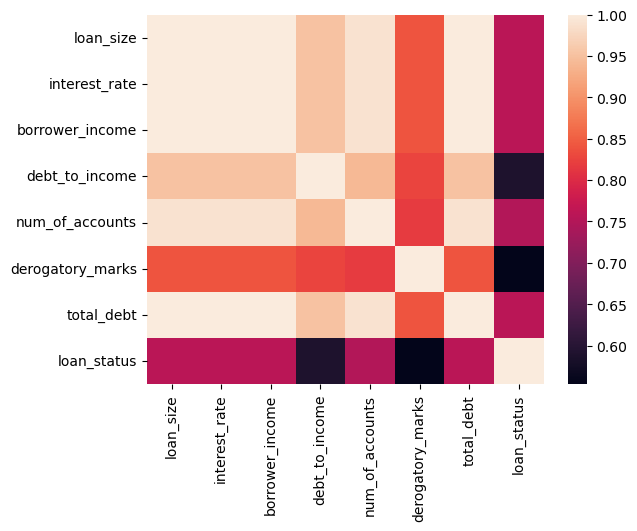

In [25]:
corrs = df.corr()
sns.heatmap(corrs)
plt.show()

In [26]:
corrs

,loan_size,interest_rate,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt,loan_status
loan_size,1.000000,0.999905,0.999893,0.951847,0.988507,0.840407,0.999893,0.758846
interest_rate,0.999905,1.000000,0.999994,0.951938,0.988515,0.840596,0.999994,0.758900
borrower_income,0.999893,0.999994,1.000000,0.951950,0.988509,0.840577,1.000000,0.758890
debt_to_income,0.951847,0.951938,0.951950,1.000000,0.941078,0.825668,0.951950,0.589305
num_of_accounts,0.988507,0.988515,0.988509,0.941078,1.000000,0.818320,0.988509,0.749802
derogatory_marks,0.840407,0.840596,0.840577,0.825668,0.818320,1.000000,0.840577,0.553187
total_debt,0.999893,0.999994,1.000000,0.951950,0.988509,0.840577,1.000000,0.758890
loan_status,0.758846,0.758900,0.758890,0.589305,0.749802,0.553187,0.758890,1.000000


In [27]:
corrs["loan_status"].sort_values(ascending=False)

loan_status         1.000000
interest_rate       0.758900
borrower_income     0.758890
total_debt          0.758890
loan_size           0.758846
num_of_accounts     0.749802
debt_to_income      0.589305
derogatory_marks    0.553187
Name: loan_status, dtype: float64

### Step 2: Create the labels set (`y`)  from the “loan_status” column, and then create the features (`X`) DataFrame from the remaining columns.

In [28]:
# Separate the data into labels and features

# Separate the X variable, the features
X = df.drop(columns=["loan_status"])

# Separate the y variable, the labels
y = df["loan_status"]

In [29]:
# Review the y variable Series
y[0:5]

0    0
1    0
2    0
3    0
4    0
Name: loan_status, dtype: int64

In [30]:
# Review the X variable DataFrame
X.head()

,loan_size,interest_rate,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt
0,10700.0,7.672,52800,0.431818,5,1,22800
1,8400.0,6.692,43600,0.311927,3,0,13600
2,9000.0,6.963,46100,0.349241,3,0,16100
3,10700.0,7.664,52700,0.430740,5,1,22700
4,10800.0,7.698,53000,0.433962,5,1,23000


### Step 3: Split the data into training and testing datasets by using `train_test_split`.

In [31]:
# Split the data using train_test_split
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(58152, 7) (58152,)
(19384, 7) (19384,)


---

## Create a Logistic Regression Model with the Original Data

In [32]:
 def doMLClassification(model, X_train, y_train, X_test, y_test):
    # fit the model
    model.fit(X_train, y_train)

    # predict the model
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    test_proba = model.predict_proba(X_test)[:,1]

    # make some pretty graphs
    print("TRAINING SET METRICS")
    print(confusion_matrix(y_train, train_preds))
    print(classification_report(y_train, train_preds))
    print()
    print("TESTING SET METRICS")
    print(confusion_matrix(y_test, test_preds))
    print(classification_report(y_test, test_preds))

    # ROC Curve
    auc = roc_auc_score(y_test, test_proba)
    fpr, tpr, thresholds = roc_curve(y_test, test_proba)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(F"AUC: {auc}")
    plt.show()

###  Step 1: Fit a logistic regression model by using the training data (`X_train` and `y_train`).
### Step 2: Save the predictions on the testing data labels by using the testing feature data (`X_test`) and the fitted model.
### Step 3: Evaluate the model’s performance by doing the following:

TRAINING SET METRICS
[[55980   297]
 [  198  1677]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56277
           1       0.85      0.89      0.87      1875

    accuracy                           0.99     58152
   macro avg       0.92      0.94      0.93     58152
weighted avg       0.99      0.99      0.99     58152


TESTING SET METRICS
[[18679    80]
 [   67   558]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18759
           1       0.87      0.89      0.88       625

    accuracy                           0.99     19384
   macro avg       0.94      0.94      0.94     19384
weighted avg       0.99      0.99      0.99     19384



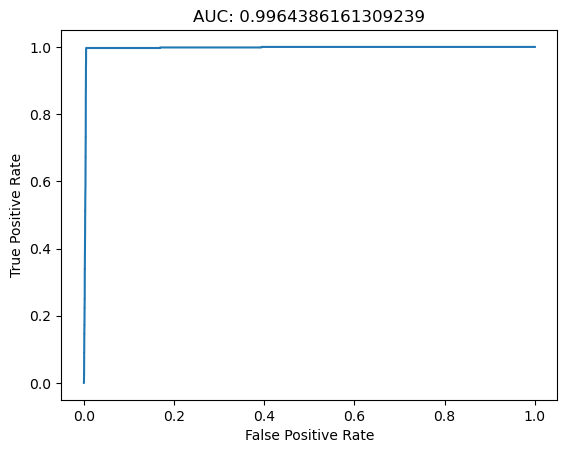

In [33]:
# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
lr = LogisticRegression()

# Fit the model using training data
doMLClassification(lr, X_train, y_train, X_test, y_test)

### Step 4: Answer the following question.

**Question:** How well does the logistic regression model predict both the `0` (healthy loan) and `1` (high-risk loan) labels?

**Answer:** It predcits with a very high accuracy in the high 90's, one might say too perfectly.

---

In [45]:
# Test Other Algorithms

TRAINING SET METRICS
[[55951   326]
 [   14  1861]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56277
           1       0.85      0.99      0.92      1875

    accuracy                           0.99     58152
   macro avg       0.93      0.99      0.96     58152
weighted avg       0.99      0.99      0.99     58152


TESTING SET METRICS
[[18669    90]
 [    5   620]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18759
           1       0.87      0.99      0.93       625

    accuracy                           1.00     19384
   macro avg       0.94      0.99      0.96     19384
weighted avg       1.00      1.00      1.00     19384



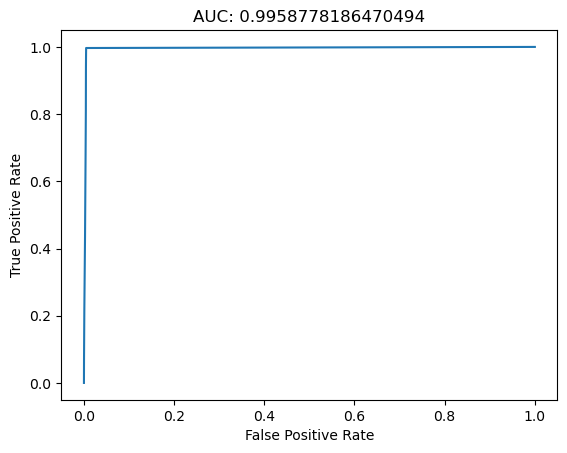

In [46]:
# init the model
knn = KNeighborsClassifier(n_neighbors=25)
doMLClassification(knn, X_train, y_train, X_test, y_test)

TRAINING SET METRICS
[[56150   127]
 [   29  1846]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56277
           1       0.94      0.98      0.96      1875

    accuracy                           1.00     58152
   macro avg       0.97      0.99      0.98     58152
weighted avg       1.00      1.00      1.00     58152


TESTING SET METRICS
[[18681    78]
 [   82   543]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18759
           1       0.87      0.87      0.87       625

    accuracy                           0.99     19384
   macro avg       0.94      0.93      0.93     19384
weighted avg       0.99      0.99      0.99     19384



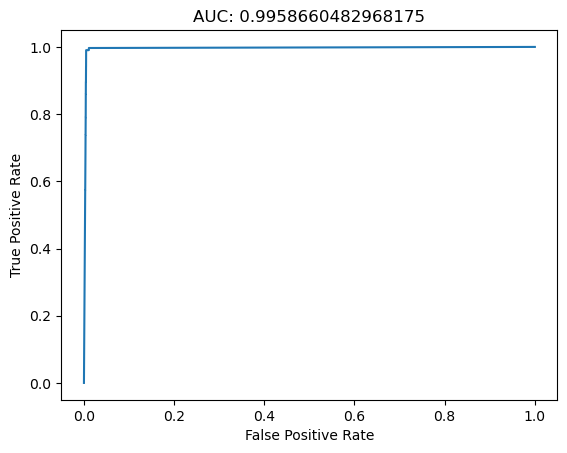

In [47]:
# init the model
rf = RandomForestClassifier(random_state=42)
doMLClassification(rf, X_train, y_train, X_test, y_test)